In [1]:
import os
import numpy as np

In [2]:
row_hic_path = '/data1/lmh_data/MINE/use_data/GM12878/hr'
epi_path = '/data1/lmh_data/MINE/use_data/GM12878/ATAC_H3K27ac_H3K4me3/epi'

In [3]:
tss_file_path = '/data1/lmh_data/MINE/source/GM12878/Homo_sapiens.GRCh38.104.chr.gff3'

def get_tss_gene_info(gene_biotype='protein_coding'):
    gene_info = []
    with open(tss_file_path, "r") as f:
        datas = f.readlines()
        for data in datas[9:]:
            data = data.split('\t')
            if len(data) < 9:
                continue
            if data[2] != 'gene' or data[8].find(gene_biotype) == -1:
                continue
            if int(data[4]) - int(data[3]) <= 3000:
                continue
            if not data[0].isdigit():
                continue
            chromosome = int(data[0])
            start, end = int(int(data[3])/1000), int(int(data[4])/1000)
            gene_info.append((chromosome, start, end))
    return gene_info

gene_info = get_tss_gene_info()

In [4]:
hic, epi = dict(), dict()
for chrom in range(1, 23):
    filename = 'chr{}_1000b.npz'.format(chrom)
    hic[chrom] = np.load(os.path.join(row_hic_path, filename))['hic'].astype(np.uint16)
    epi[chrom] = np.load(os.path.join(epi_path, filename))['epi'].astype(np.uint16)

In [5]:
_result, nums = None, 0
for chrom in range(1, 23):
    _hic, _epi = hic[chrom], epi[chrom]
    
    for info in gene_info:
        if info[0] != chrom:
            continue
        _win = int(info[1]/400)
        if _win != int(info[2]/400):
            continue
        _start, _end = info[1]-400*_win, info[2]-400*_win
        if _start==0 or _end==399:
            continue
        __epi = _epi[_win, 0, _start-1:_start+2, _end-1:_end+2]
        if __epi.max() == 0:
            continue
        __epi = __epi / __epi.max()
        if _result is not None:
            _result += __epi
        else:
            _result = __epi
        nums += 1
_result

array([[6122.3472984 , 7151.49563309, 5689.94482182],
       [7680.93518317, 8730.63927502, 7161.29970378],
       [6585.14890008, 7653.74790981, 6128.99619967]])

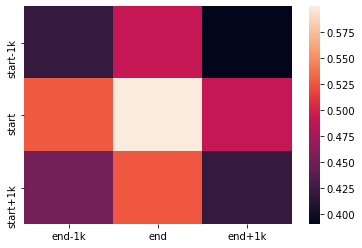

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
df = pd.DataFrame(_result/nums, columns=['end-1k', 'end', 'end+1k'], index=['start-1k', 'start', 'start+1k'])
sns.heatmap(df)
plt.savefig('figure_file/epi_matrix.pdf', format='pdf', bbox_inches='tight')
plt.show()